# resautonet: A Library of Autoencoder-based Residual Deep Network 

### Construction, use and performance analysis of autoencoder-basd residual deep network ### 

In this architecture, 
    * autoencoder is the internal base for a balance connection from the encoding to decoding layers
    * residual connection is constructed in a nested way and the critical component to improve the training time and stability 
    
The following left plot shows the network archtecture and the right one shows three options for the topology of residual connections. 
<img  align="left" src="figs/fig1.png" width="800"  height="200"  hspace="20"/>


In this note, we use two datasets, i.e. simmulated dataset and real PM<sub>2.5</sub> dataset to illustrate use of the library and comparison of residual and regular networks.  

### Installation of the package 

    (1) You can directly install this package using the following command for the latest version:
          pip install resautonet -U  
    (2) You can also clone the repository and then install:
         git clone --recursive https://github.com/lspatial/resautonet.git
         cd resautonet 
         pip install ./setup.py install 

The following code is to import the necessary packages: 

In [1]:
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
import pandas as pd 
import keras 
from keras.callbacks import ModelCheckpoint

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import resautonet 

/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


## Test 1: the simulated dataset 

The dataset is simulated using the following formula: 
    \begin{equation}
          y=x_1+x_2*\sqrt{x_3}+x_4+(x_5/500)^{0.3}-x_6+\sqrt{x_7} + x_8 + \epsilon
     \end{equation}
each covariate defined as:
\begin{equation}
       x_1 \sim U(1,100), x_2 \sim U(0,100), x_3 \sim U(1,10), x_4 \sim U(1,100),  
       x_5 \sim U(9,100),x_6 \sim U(1,1009),x_7 \sim U(5,300),x_8~U(6 \sim 200)
\end{equation}

Use the following function to generate the simulated dataset: 

In [2]:
simdata=resautonet.simData()
simdata.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y
0,61.352888,98.650301,6.458567,25.058539,17.909715,447.422895,132.946732,146.852385,202.549117
1,6.994791,51.456171,2.105735,51.649147,26.575460,114.674527,259.205695,95.805720,76.062847
2,13.685065,80.172151,6.590211,85.191893,74.691194,810.343415,101.088590,31.447991,-432.972966
3,4.758604,58.519233,6.962512,9.208707,35.137663,881.411676,144.520525,122.706545,-470.152339
4,33.517461,66.136145,5.418776,51.991921,78.219501,538.206793,86.859919,86.416299,-297.210939


You can also load the dataset existing in the package for a test: 

In [3]:
simdata=resautonet.data('sim')
simdata.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y
index,,,,,,,,,
0,5.913603,7.856468,7.676701,59.488758,69.569988,182.941587,191.963120,87.314893,13.934329
1,43.977562,85.455399,8.209722,15.106148,46.131332,768.770945,197.264480,136.956539,-205.813208
2,78.462677,7.745484,5.766864,75.614158,33.145528,839.338362,149.268020,128.706578,-629.562431
3,30.656661,99.536410,9.184463,94.195816,99.443974,436.162144,67.876023,156.864481,194.970310
4,34.247640,83.544456,5.030490,16.033990,79.278488,553.426601,31.581614,124.261841,-212.494467


Then the pandas's data frame is converted into the numpy array for the models: 

In [4]:
tcol=['x'+str(i) for i in range(1,9)]
X=simdata[tcol].values 
y=simdata['y'].values
y=y.reshape((y.shape[0],1))

The data is normalized using the tool of standard scaler: 

In [5]:
scX = preprocessing.StandardScaler().fit(X)
scy = preprocessing.StandardScaler().fit(y)
Xn=scX.transform(X)
yn=scy.transform(y)
print(np.min(y),np.max(y))

-943.1592199858045 663.3099522511869


Then, the dataset's samples are separated into three parts, training, validation and test:

In [6]:
x_train, x_test, y_train,y_test = train_test_split(Xn,yn,
                                      test_size=0.2)
x_train, x_valid, y_train,y_valid = train_test_split(x_train,y_train,
                                      test_size=0.2)
print(x_train.shape,x_valid.shape,y_train.shape,y_valid.shape)

(768, 8) (192, 8) (768, 1) (192, 1)


Call the major class,  resAutoencoder from resautonet to obtain the network. 
Critical network parameters: 
        * nfea: 8 ; 
        * layernNodes: [32,16,8,4] ;
        * acts: 'relu';
        * extranOutput: 1 ;
        * batchnorm: True ;
        * reg:  L1 and L2 ;
        * inresidual: True (residual network);
        * defact: 'tanh' ;
        * outputtype: 0, just the target variable to be output. 

In [7]:
from resautonet.model import r2KAuto,r2K
#Set the path to save the model's parameters 
wtPath='/tmp/res_sim_wei.hdf5'
# Set the check point to check the validation 
checkpointw=ModelCheckpoint(wtPath, monitor="loss",verbose=0, save_best_only=True, mode="min")
#Call the model class 
modelCls = resautonet.model.resAutoencoder(x_train.shape[1], [32,16,8,4],'relu',1,inresidual=True,reg=keras.regularizers.l1_l2(0),
                          batchnorm=True,outnres=None,defact='linear',outputtype=0)
#Get the residual autoencoder network 
resmodel = modelCls.resAutoNet()
#Show the network model's topology 
resmodel.summary()
#Complie the network model 
resmodel.compile(optimizer="adam", loss= 'mean_squared_error',#mean_squared_error bce_dice_loss, #jaccard_coef_loss, jaccardent_coef_loss1
      metrics=['mean_squared_error',r2KAuto,r2K])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feat (InputLayer)               (None, 8)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           288         feat[0][0]                       
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32)           128         dense_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32)           0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [8]:
#Starting to train the model... ... 
fhist_res=resmodel.fit(x_train, y_train, batch_size=128, epochs=200, verbose=0, shuffle=True,
           validation_data=(x_valid, y_valid),callbacks=[checkpointw])

Test the independent dataset using the trained model. RMSE and Rsquared are used as the metrics.  

In [9]:
from resautonet.model import rsquared, rmse 
resmodel.load_weights(wtPath)
resmodel.compile(optimizer="adam", loss= 'mean_squared_error',  metrics=['mean_squared_error',r2KAuto,r2K])
y_test_pred=resmodel.predict(x_test)

obs=scy.inverse_transform(y_test[:,-1])
preres=scy.inverse_transform(y_test_pred[:,-1])

r2_res=rsquared(obs,preres)
rmse_res=rmse(obs,preres)
print("indepdendent test for residual deep network: r2-",r2_res,"rmse:",rmse_res)

indepdendent test for residual deep network: r2- 0.8597980628880261 rmse: 118.06089494727486


Call the major class,  resAutoencoder from resautonet to obtain the network without residual connection, i.e. regular autoencoder deep network bying setting the argument of inresidual as False (the other arguments are the same):  

In [10]:
wtPath_no='/tmp/nores_sim_wei.hdf5'
checkpointw=ModelCheckpoint(wtPath, monitor="loss",verbose=0, save_best_only=True, mode="min")
    
modelCls =resautonet.model.resAutoencoder(x_train.shape[1], [32,16,8,4],'relu',1,inresidual=False,reg=keras.regularizers.l1_l2(0),
                          batchnorm=True,outnres=None,defact='linear',outputtype=0)
noresmodel = modelCls.resAutoNet()
noresmodel.summary()
noresmodel.compile(optimizer="adam", loss= 'mean_squared_error',#mean_squared_error bce_dice_loss, #jaccard_coef_loss, jaccardent_coef_loss1
      metrics=['mean_squared_error',r2KAuto,r2K])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feat (InputLayer)            (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                288       
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_13 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 32)                128       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_22 (Batc (None, 16)                64        
__________

In [11]:
#Train the regular network 
fhist_nores=noresmodel.fit(x_train, y_train, batch_size=64, epochs=200, verbose=0, shuffle=True,
           validation_data=(x_valid, y_valid),callbacks=[checkpointw])

In [12]:
noresmodel.load_weights(wtPath_no)
noresmodel.compile(optimizer="adam", loss= 'mean_squared_error',  metrics=['mean_squared_error',r2KAuto,r2K])
y_test_pred=noresmodel.predict(x_test)

obs=scy.inverse_transform(y_test[:,-1])
prenores=scy.inverse_transform(y_test_pred[:,-1])

r2_nores=rsquared(obs,prenores)
rmse_nores=rmse(obs,prenores)
print("indepdendent test for regular autoencoder network: r2-",r2_nores,"rmse:",rmse_nores)

indepdendent test for regular autoencoder network: r2- 0.7192458074526653 rmse: 167.06758280917833


Then compare the scatter plots of residual deep network and regular network to see the difference in the distributions of their predictions : 

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')

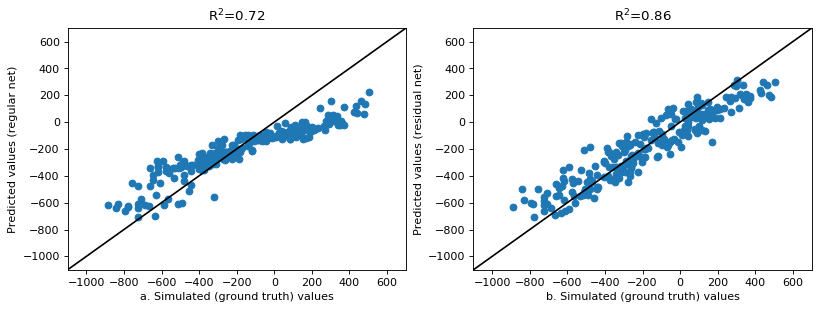

In [14]:
plt.figure(num=None, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(obs,prenores)
plt.xlim(-1100,700)
plt.ylim(-1100,700)
#plt.axis('equal')
plt.title("$\mathregular{R^2}$="+str(np.round(r2_nores,2)))
plt.xlabel("a. Simulated (ground truth) values")
plt.ylabel('Predicted values (regular net)')
x=[-1100 , 700]
y=[ -1100, 700]
connectpoints(x,y,0,1)
plt.subplot(122)
plt.scatter(obs,preres)
plt.xlim(-1100,700)
plt.ylim(-1100,700)
#plt.axis('equal')
plt.title("$\mathregular{R^2}$="+str(np.round(r2_res,2)))
plt.xlabel("b. Simulated (ground truth) values")
plt.ylabel('Predicted values (residual net)')
x=[-1100 , 700]
y=[ -1100, 700]
connectpoints(x,y,0,1)
plt.show()

Compare the training curves of RMSE and R<sup>2</sup>  of residual deep network to check the difference in convergence and training efficiency: 

In [15]:
rhDf_nores=pd.DataFrame(fhist_nores.history) 
rhDf_res=pd.DataFrame(fhist_res.history) 
rhDf_nores['epoch']=pd.Series(np.arange(1,len(rhDf_nores)+1))
rhDf_res['epoch']=pd.Series(np.arange(1,len(rhDf_res)+1))

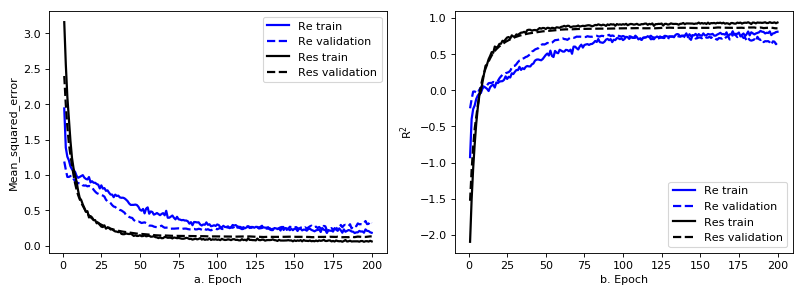

In [16]:
plt.figure(num=None, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot( 'epoch', 'mean_squared_error', data=rhDf_nores, marker='', markerfacecolor='blue', markersize=12, color='blue', linewidth=2,label='Re train')
plt.plot( 'epoch', 'val_mean_squared_error', data=rhDf_nores, marker='', color='blue', linewidth=2,linestyle='dashed',label="Re validation")
plt.plot( 'epoch', 'mean_squared_error', data=rhDf_res,marker='', color='black', linewidth=2, label="Res train")
plt.plot( 'epoch', 'val_mean_squared_error', data=rhDf_res,marker='', color='black', linewidth=2, linestyle='dashed', label="Res validation")
plt.legend()
plt.xlabel('a. Epoch')
plt.ylabel('Mean_squared_error')
plt.subplot(122)
plt.plot( 'epoch', 'r2KAuto', data=rhDf_nores, marker='', markerfacecolor='blue', markersize=12, color='blue', linewidth=2,label='Re train')
plt.plot( 'epoch', 'val_r2KAuto', data=rhDf_nores, marker='', color='blue', linewidth=2,linestyle='dashed',label="Re validation")
plt.plot( 'epoch', 'r2KAuto', data=rhDf_res,marker='', color='black', linewidth=2, label="Res train")
plt.plot( 'epoch', 'val_r2KAuto', data=rhDf_res,marker='', color='black', linewidth=2, linestyle='dashed', label="Res validation")
plt.legend()
plt.xlabel('b. Epoch')
plt.ylabel(r'$\mathregular{R^2}$') 
plt.show()

## Test 2: real PM<sub>2.5</sub> dataset and relevant covariates for the Beijing-Tianjin_Tangshan area

 This dataset is the real dataset of the 2015 PM<sub>2.5</sub> and the relevant covariates for the Beijing-Tianjin-Tangshan area. It is sampled by the fraction of 0.8 from the  original dataset (stratified by the julian day). 
<img  align="left" src="figs/fig2.png" width="800"  height="550"  hspace="10"/>

First, load the dataset as pandas's DataFrame: 

In [17]:
pm25data=resautonet.data('pm2.5')
pm25data.head()

,sites,site_name,city,lon,lat,pm25_davg,ele,prs,tem,rhu,...,aod,date,haod,shaod,jd,pblh_re,pre_re,o3_re,merra2_re,month
index,,,,,,,,,,,,,,,,,,,,,
0,榆垡,京南榆垡，京南区域点,北京,116.300,39.520,96.160870,18,1020.244080,-0.003921,36.598670,...,0.242638,2015-01-01,0.001804,0.001144,1,134.486526,1.871046e-15,322.445557,0.138301,1
1,西直门北,西直门北大街，西直门交通点,北京,116.349,39.954,48.430435,55,1015.730225,-0.432289,35.865617,...,0.222919,2015-01-01,0.001975,0.001266,1,112.893944,2.875803e-15,322.874084,0.138507,1
2,平谷,平谷镇,北京,117.100,40.143,34.226087,31,1018.659729,-0.540426,36.612362,...,0.102925,2015-01-01,0.001081,0.000685,1,95.175110,2.632787e-15,327.405518,0.140614,1
3,大兴,大兴黄村镇,北京,116.404,39.718,62.608696,39,1017.720398,-0.175816,36.385316,...,0.238552,2015-01-01,0.001942,0.001235,1,122.864220,1.406891e-15,323.216187,0.138756,1
4,永定门内,永定门内大街，永定门交通点,北京,116.394,39.876,53.795652,52,1016.125244,-0.321042,35.965937,...,0.227112,2015-01-01,0.001963,0.001257,1,115.717644,2.103999e-15,323.141327,0.138746,1


In [18]:
#Derive the more variables for the coordinates to capture spatial variation: 
tcols=['lat','lon','ele','prs','tem','rhu','win','aod',
       'pblh_re','pre_re','o3_re','merra2_re','haod','shaod','jd']
pm25data['lat2']=pm25data['lat']*pm25data['lat']
pm25data['lon2']=pm25data['lon']*pm25data['lon']
pm25data['latlon']=pm25data['lat']*pm25data['lon']
tcols.extend(['lat2','lon2','latlon'])

In [19]:
# Data preprocesing, log transformation and normailization: 
X=pm25data[tcols]
y=np.log(pm25data['pm25_davg'])
y=y.reshape((y.shape[0],1))
scX = preprocessing.StandardScaler().fit(X)
scy = preprocessing.StandardScaler().fit(y)
Xn=scX.transform(X)
yn=scy.transform(y)

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


In [20]:
#Split the dataset into the sets of training, validation and test 
x_train, x_test, y_train,y_test = train_test_split(Xn,yn,
                                      test_size=0.2,stratify=pm25data['jd'].values)
x_train, x_valid, y_train,y_valid = train_test_split(x_train,y_train,
                                      test_size=0.2,stratify=x_train[:,-1])
print(x_train.shape,x_valid.shape,y_train.shape,y_valid.shape,x_test.shape)

(13549, 18) (3388, 18) (13549, 1) (3388, 1) (4235, 18)


Call the major class,  resAutoencoder from resautonet to obtain the network. 
Critical network parameters: 
        * nfea: 18 ; 
        * layernNodes:[128,96,64,32,16,8] ;
        * acts: 'relu';
        * reg: L1 and L2 ;
        * inresidual: True (residual network);
        * defact: 'linear' ;
        * dropout: 0.1 
        * outputtype: 0, just the target variable to be output. 

In [21]:
modelCls = resautonet.model.resAutoencoder(x_train.shape[1], [128,96,64,32,16,8],'relu',1,
        reg=keras.regularizers.l1_l2(0),inresidual=True,outnres=None,dropout=0.1,defact='linear')
resmodel = modelCls.resAutoNet()
resmodel.summary()
resmodel.compile(optimizer="adam", loss= 'mean_squared_error',#'mean_squared_error',#mean_squared_error bce_dice_loss, #jaccard_coef_loss, jaccardent_coef_loss1
      metrics=['mean_squared_error',r2K,r2KAuto])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feat (InputLayer)               (None, 18)           0                                            
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 128)          2432        feat[0][0]                       
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 128)          512         dense_19[0][0]                   
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 128)          0           batch_normalization_35[0][0]     
__________________________________________________________________________________________________
batch_norm

Staring to train the model:

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
# Set the file path to save the model's parameters 
modelFl='/tmp/pm25model_res.wei'
checkpoint = ModelCheckpoint(modelFl, monitor='loss', verbose=0, save_best_only=True, mode='min',
                                 save_weights_only=True)
reduceLROnPlat = ReduceLROnPlateau(monitor='loss', factor=0.1,
                                       patience=1, verbose=0, mode='min',
                                       min_delta=0.0001, cooldown=0, min_lr=1e-8)
early = EarlyStopping(monitor='loss', mode="min", verbose=0,
                          patience=200)

fhist_res=resmodel.fit(x_train, y_train, batch_size=256, epochs=100, verbose=0, shuffle=True,
           validation_data=(x_valid, y_valid),callbacks=[early, checkpoint, reduceLROnPlat])


Test the independent dataset using the trained model. RMSE and Rsquared are used as the metrics.  

In [23]:
resmodel.load_weights(modelFl)
resmodel.compile(optimizer="adam", loss= 'mean_squared_error',#'mean_squared_error',#mean_squared_error bce_dice_loss, #jaccard_coef_loss, jaccardent_coef_loss1
      metrics=['mean_squared_error',r2K,r2KAuto])

y_test_pred=resmodel.predict(x_test)

obs=np.exp(scy.inverse_transform(y_test[:,-1]))
preres=np.exp(scy.inverse_transform(y_test_pred[:,-1]))

r2_res=rsquared(obs,preres)
rmse_res=rmse(obs,preres)
print("indepdendent test:r2-",r2_res,"rmse:",rmse_res)

indepdendent test:r2- 0.8673833162656025 rmse: 25.903231367848974


Call the major class,  resAutoencoder from resautonet to obtain the network without residual connection, i.e. regular autoencoder deep network bying setting the argument of inresidual as False (the other arguments are the same):  

In [24]:
modelCls =resautonet.model.resAutoencoder(x_train.shape[1], [128,96,64,32,16,8],'relu',1,
        reg=keras.regularizers.l1_l2(0),inresidual=False,outnres=None,dropout=0.1,defact='linear')
noresmodel = modelCls.resAutoNet()
noresmodel.summary()
noresmodel.compile(optimizer="adam", loss= 'mean_squared_error',#'mean_squared_error',#mean_squared_error bce_dice_loss, #jaccard_coef_loss, jaccardent_coef_loss1
      metrics=['mean_squared_error',r2K,r2KAuto])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feat (InputLayer)            (None, 18)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               2432      
_________________________________________________________________
batch_normalization_64 (Batc (None, 128)               512       
_________________________________________________________________
activation_39 (Activation)   (None, 128)               0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 128)               512       
_________________________________________________________________
dense_33 (Dense)             (None, 96)                12384     
_________________________________________________________________
batch_normalization_66 (Batc (None, 96)                384       
__________

Staring to train the model of regular network (no residual connections) :

In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 

modelFl='/tmp/pm25model_nores.wei'
checkpoint = ModelCheckpoint(modelFl, monitor='loss', verbose=0, save_best_only=True, mode='min',
                                 save_weights_only=True)
reduceLROnPlat = ReduceLROnPlateau(monitor='loss', factor=0.1,
                                       patience=1, verbose=0, mode='min',
                                       min_delta=0.0001, cooldown=0, min_lr=1e-8)
early = EarlyStopping(monitor='loss', mode="min", verbose=0,
                          patience=200)

fhist_nores=noresmodel.fit(x_train, y_train, batch_size=1000, epochs=100, verbose=0, shuffle=True,
           validation_data=(x_valid, y_valid),callbacks=[early, checkpoint, reduceLROnPlat])

Test the independent dataset using the trained model. RMSE and Rsquared are used as the metrics. 

In [26]:
noresmodel.load_weights(modelFl)
noresmodel.compile(optimizer="adam", loss= 'mean_squared_error',#'mean_squared_error',#mean_squared_error bce_dice_loss, #jaccard_coef_loss, jaccardent_coef_loss1
      metrics=['mean_squared_error',r2K,r2KAuto])

y_test_pred=noresmodel.predict(x_test)

obs=np.exp(scy.inverse_transform(y_test[:,-1]))
prenores=np.exp(scy.inverse_transform(y_test_pred[:,-1]))

r2_nores=rsquared(obs,prenores)
rmse_nores=rmse(obs,prenores)
print("indepdendent test:r2-",r2_nores,"rmse:",rmse_nores)

indepdendent test:r2- 0.5150908539440606 rmse: 49.531907212536936


Then compare the scatter plots of residual deep network and regular network to see the difference in the distributions of their predictions : 

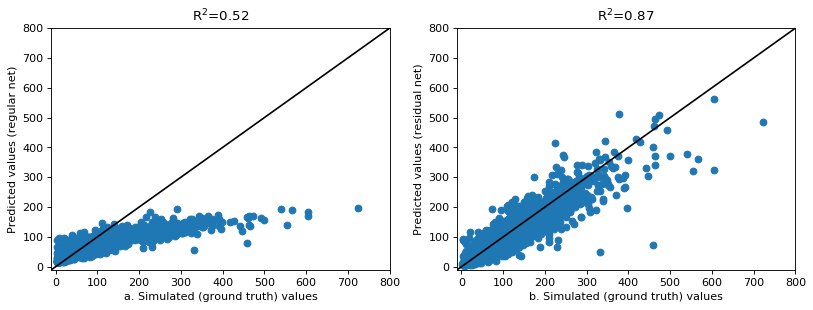

In [27]:
plt.figure(num=None, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.scatter(obs,prenores)
plt.xlim(-10,800)
plt.ylim(-10,800)
#plt.axis('equal')
plt.title("$\mathregular{R^2}$="+str(np.round(r2_nores,2)))
plt.xlabel("a. Simulated (ground truth) values")
plt.ylabel('Predicted values (regular net)')
x=[-10 , 800]
y=[ -10, 800]
connectpoints(x,y,0,1)
plt.subplot(122)
plt.scatter(obs,preres)
plt.xlim(-10,800)
plt.ylim(-10,800)
#plt.axis('equal')
plt.title("$\mathregular{R^2}$="+str(np.round(r2_res,2)))
plt.xlabel("b. Simulated (ground truth) values")
plt.ylabel('Predicted values (residual net)')
x=[-10 , 800]
y=[ -10, 800]
connectpoints(x,y,0,1)
plt.show()

Compare the training curves of RMSE and R<sup>2</sup>  of residual deep network to check the difference in convergence and training efficiency: 

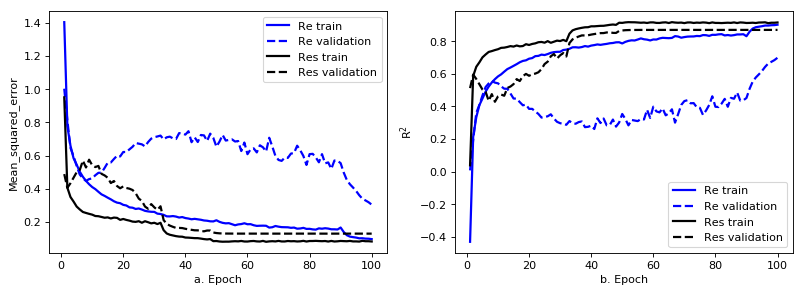

In [28]:
rhDf_nores=pd.DataFrame(fhist_nores.history) 
rhDf_res=pd.DataFrame(fhist_res.history) 
rhDf_nores['epoch']=pd.Series(np.arange(1,len(rhDf_nores)+1))
rhDf_res['epoch']=pd.Series(np.arange(1,len(rhDf_res)+1))
rhDf_res['mean_squared_error'].shape 

plt.figure(num=None, figsize=(12,4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.plot( 'epoch', 'mean_squared_error', data=rhDf_nores, marker='', markerfacecolor='blue', markersize=12, color='blue', linewidth=2,label='Re train')
plt.plot( 'epoch', 'val_mean_squared_error', data=rhDf_nores, marker='', color='blue', linewidth=2,linestyle='dashed',label="Re validation")
plt.plot( 'epoch', 'mean_squared_error', data=rhDf_res,marker='', color='black', linewidth=2, label="Res train")
plt.plot( 'epoch', 'val_mean_squared_error', data=rhDf_res,marker='', color='black', linewidth=2, linestyle='dashed', label="Res validation")
plt.legend()
plt.xlabel('a. Epoch')
plt.ylabel('Mean_squared_error')
plt.subplot(122)
plt.plot( 'epoch', 'r2KAuto', data=rhDf_nores, marker='', markerfacecolor='blue', markersize=12, color='blue', linewidth=2,label='Re train')
plt.plot( 'epoch', 'val_r2KAuto', data=rhDf_nores, marker='', color='blue', linewidth=2,linestyle='dashed',label="Re validation")
plt.plot( 'epoch', 'r2KAuto', data=rhDf_res,marker='', color='black', linewidth=2, label="Res train")
plt.plot( 'epoch', 'val_r2KAuto', data=rhDf_res,marker='', color='black', linewidth=2, linestyle='dashed', label="Res validation")
plt.legend()
plt.xlabel('b. Epoch')
plt.ylabel(r'$\mathregular{R^2}$') 
plt.show()

#### Comparison with the independent monitoring data from US embassy in Beijing

Using the residual deep network, we made the 2015 daily surfaces of PM<sub>2.5</sub> concentrations ($\mu$g/m<sup>3</sup>) (365 surfaces) for  the Beijing-Tianjin_tanshan area and extracted its daily predicted values of 2015 for the monitroing station of air quality of the US embassy in Beijing. We made the comparison between the observed and predicted values.  R<sup>2<\sup>=0.97 and RMSE=13.23 $\mu$g/m<sup>3</sup>. We also made the scatter plots and time series of the residuals to observe discernable pattern. The random pattern indicates spatiotemporal variability of PM<sub>2.5</sub> has been captured by our models. The predicted and observed values match each other perfectly. 
<img  align="left" src="figs/usembassy.png" width="800"  height="700"  hspace="10"/>

_*  For this library and its relevant applications, welcome to contact Dr. Lianfa Li. *_
 - Email: lspatial@gmail.com